# Regresión Logística

Uno de los modelos de clasificación más simples que existe, el modelo de regresión logística consiste en una red neuronal de una celda cuya función de activación es la logística:

$$
\sigma(z) = \frac{1}{1+e^{-z}}
$$

Reemplazando con $z = w^T \cdot x + b$ una transformación afín del vector de entrada $x$ vía el vector de pesos $w$ y el sesgo $b$, se obtiene que el modelo $h(x)$ es

$$
h(x) = \sigma(w^T  \cdot x+b) = \frac{1}{1+e^{-(w^T  \cdot x+b)}}
$$

cuya salida es un valor entre 0 y 1, interpretable a su vez en un esquema de clasificación binaria (las clases posibles son $0$ y $1$) como *la probabilidad de que ese $x$ pertenezca a la clase 1*.


## Forward propagation (predicción)

Dada una función de pérdida $\mathcal{L}(y,\hat{y})$, se puede definir la función de costo $J(W,b)=\frac{1}{n}\sum_{i=1}^n\mathcal{L}(y_i,h_{W,b}(x_i))$ que es la pérdida promedio. En el caso de utilizar SGD podemos estimar esto en base al error sobre un sample.


![](https://drive.google.com/uc?id=1_whFVq37nx53d_f-jRCI68vIUv63T5_f)


## Backwards propagation (actualización)
![](https://drive.google.com/uc?id=11uQs3-MC3mtq0la7i8EFuofSkrjxiKKw)

donde:
* $\frac{dL}{d\sigma}$ depende de la función de pérdida utilizada
* $\frac{d\sigma}{dz} = \sigma'(z) = \sigma(z)(1-\sigma(z))$ es la derivada de la función logística
* $\nabla z (w) = x$ que se puede obtener fácilmente observando que $z=b+\sum_{i=1}^n w_i \cdot x_i$ y luego para todo $i$ resulta $\frac{dz}{dw_i}=x_i$ y de la misma forma  $\frac{dz}{dx_i}=w_i$, luego $\nabla z (w) = x$ y $\nabla z (x) = w$, aunque este último no resulta de interés para una red neuronal no-multicapa.
* $\frac{dz}{db}=1$



## Función de pérdida: Cross-entropy

Vamos a utilizar, para el esquema de clasificación binaria (las clases son $0$ o $1$) la función de pérdida conocida como *log-loss* o [*cross-entropy loss*](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression), que se define como:

$$
\mathcal{L}(y,\hat{y}) = -y \cdot log(\hat{y}) - (1-y) \cdot log(1-\hat{y})
$$

Al margen de las muchas propiedades que exhibe la utilización de esa función de pérdida (cuya minimización, por ejemplo, es equivalente a maximizar la verosimilitud de los datos), su derivada resulta muy práctica por cómo se acopla con la derivada respecto de $z$:

$$
\frac{d\mathcal{L}(y,\hat{y})}{d\hat{y}} = \frac{\hat{y}-y}{\hat{y}(1-\hat{y})}
$$

de donde
$$
\frac{d\mathcal{L}(y,\sigma(z))}{dz} = \frac{d\mathcal{L}(y,\sigma)}{d\sigma} \cdot \frac{\sigma(z)}{dz} = \frac{\sigma(z)-y}{\sigma(z)(1-\sigma(z))} \cdot \sigma(z)(1-\sigma(z)) = \sigma(z) - y
$$

y por tanto el $\frac{dJ}{dz}$ coincide con el del modelo de regresión lineal cuando se utiliza el error cuadrático medio como función de pérdida, además de ahorrar muchas cuentas.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
# random seeds
rng_seed = 1234

In [ ]:
# datos
from sklearn.datasets import load_breast_cancer
X, Y = load_breast_cancer(return_X_y=True)

# separamos en set de train y test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=rng_seed)

n_rows = X_train.shape[0]
dims = X_train.shape[1]

n_rows, dims

(398, 30)

In [ ]:
# inicialización
rng = np.random.default_rng(rng_seed)

w = rng.standard_normal(size=(dims)) * 0.01
b = rng.uniform(size=1)

w,b

(array([-0.01603837,  0.000641  ,  0.00740891,  0.00152619,  0.00863744,
         0.02913099, -0.01478823,  0.00945473, -0.01666135,  0.00343745,
        -0.00512444,  0.01323759, -0.0086028 ,  0.00519493, -0.01265144,
        -0.02159139,  0.00434734,  0.01733289,  0.00520134, -0.01002166,
         0.00268346,  0.00767175,  0.01191272, -0.01157411,  0.00696279,
         0.00351384, -0.00032415,  0.00013182, -0.0067925 , -0.00620532]),
 array([0.73581899]))

In [ ]:
w,b

(array([-0.01603837,  0.000641  ,  0.00740891,  0.00152619,  0.00863744,
         0.02913099, -0.01478823,  0.00945473, -0.01666135,  0.00343745,
        -0.00512444,  0.01323759, -0.0086028 ,  0.00519493, -0.01265144,
        -0.02159139,  0.00434734,  0.01733289,  0.00520134, -0.01002166,
         0.00268346,  0.00767175,  0.01191272, -0.01157411,  0.00696279,
         0.00351384, -0.00032415,  0.00013182, -0.0067925 , -0.00620532]),
 array([0.73581899]))

In [ ]:
# pre-train validation error

# aprovechamos propiedades y vectorización para hacer las cosas más rápido
# X es (n_rows, dims)
# w es (dims,1)
# b es (,) (escalar)
def val_error(X_val,Y_val,w,b):
  Z = X_val @ w.reshape((w.size,1)) + b
  Y_hat = 1./(1+np.exp(-Z))

  Y_val = Y_val.reshape((Y_val.size,1))

  log_loss_v = Y_val * np.log(Y_hat) + (1-Y_val)* np.log(1-Y_hat)

  #print(f"log_loss fun has shape {log_loss_v.shape} and Y_val has shape {Y_val.shape} and Y_hat has shape {Y_hat.shape}")

  return -np.average(log_loss_v)

print(f"Pre-train average loss: {val_error(X_test,Y_test,w,b)}")

Pre-train average loss: 1.9783711582850736


In [ ]:
# run
n_runs = 10        # cuántas veces correr el ciclo
lr = 0.001         # learning rate del VGD, tuneable


for i in range(n_runs):

  # sample para SGD
  idx = rng.choice(n_rows)
  x = X_train[idx]
  y = Y_train[idx]

  # forward
  z = w @ x + b
  y_hat = 1./(1+np.exp(-z))

  # evaluation
  print(f"{i+1}-th run average validation loss: {val_error(X_test,Y_test,w,b)}")
  
  # backwards
  ## derivatives
  # notacion (convencional?) decir dz significa dL/dz
  dz = y_hat - y
  dw = x * dz
  db = dz

  ## vanilla gradient descent (VGD)
  w -= lr * dw
  b -= lr * db

1-th run average validation loss: 1.9783711582850736
2-th run average validation loss: nan
3-th run average validation loss: nan
4-th run average validation loss: nan
5-th run average validation loss: nan
6-th run average validation loss: nan
7-th run average validation loss: nan
8-th run average validation loss: nan
9-th run average validation loss: nan
10-th run average validation loss: nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


¿Qué pasó? Está dando error desde la primer actualización de los parámetros! A ver las salidas...

In [ ]:
# chequeo de los parámetros, nada raro por aquí
w,b

(array([-9.44993022e-04,  2.41410356e-02,  9.35744806e-02,  2.57760978e-01,
         8.75463393e-03,  2.89903293e-02, -1.50761182e-02,  9.36166269e-03,
        -1.63706911e-02,  3.54150759e-03, -4.98708292e-03,  1.45055822e-02,
        -8.89534482e-03, -6.83756090e-04, -1.26492452e-02, -2.16430881e-02,
         4.29173374e-03,  1.73286726e-02,  5.23236312e-03, -1.00222740e-02,
         1.75756242e-02,  2.90353542e-02,  8.79926045e-02,  1.53289795e-01,
         7.07174880e-03,  2.83988644e-03, -1.16651719e-03, -8.94947389e-05,
        -6.43296459e-03, -6.13924909e-03]), array([0.73774624]))

In [ ]:
# sólo la transformación afin
Z__ = (X_test @ w.reshape((w.size,1)) + b).round(3).flatten()
Z__

array([ 208.644,  170.056,  230.158,  133.995,  273.659,  240.978,
        349.749,  111.704,  532.468,  479.48 ,  632.073,  321.46 ,
        223.355,  359.293,  204.667,  600.629,  218.596,  129.119,
        202.387,  424.388,  271.392,  458.834,  610.411,  915.51 ,
        671.876,  302.418,  309.561,  195.138,  181.655,  233.628,
        249.169,  220.224,  576.539,  240.895,  175.091,  302.821,
        163.316,  386.095,  369.044,  152.706,  461.111,  184.243,
        605.808,  234.399,  241.647,  121.214,  172.184,  295.236,
        712.781,  278.741,  291.741,  318.738,  207.675,  639.759,
        410.736,  231.657,  123.624,  168.36 ,  221.983,  437.532,
        311.292,  146.106,  276.41 ,  156.326,  249.095,  445.552,
        596.848,  190.024,  188.364,  285.365,  131.896,  424.721,
        111.982,  219.648,  271.235,  147.685,  160.139,  622.725,
        185.741,  341.925,  211.615,  237.584,  374.957,  336.188,
        450.844,  425.317,  472.881,  610.059,  328.173,  307.

In [ ]:
(1./(1+np.exp(-Z__))).round(4).flatten()

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.])

Como se puede apreciar, al haber 1s (o 0s) absolutos el log(0) genera un $\infty$, que a su vez provoca un overflow. 

¿Es un problema de alguna columna que tiene rangos muy grandes? Si así lo fuera, estandarizar las columnas debería resolver el problema.

In [ ]:
def standardize_cols(mat, mean=None, std=None):
  if mean is None:
    mean = mat.mean(axis=0)
  mat -= mean

  if std is None:
    std = mat.std(axis=0)
  mat /= std

  return mat, mean, std


# estandarizamos el X_train
X_train_std, means, stds = standardize_cols(X_train.copy())

# aplicamos la misma transf al set de test 
X_test_std, _, _ = standardize_cols(X_test.copy(), mean=means, std=stds)

In [ ]:
# reiniciamos todo y volvemos a correr
w = rng.standard_normal(size=(dims)) * 0.01
b = rng.uniform(size=1)

for i in range(n_runs):

  # sample para SGD
  idx = rng.choice(n_rows)
  x = X_train_std[idx]
  y = Y_train[idx]

  # forward
  z = w @ x + b
  y_hat = 1./(1+np.exp(-z))

  # evaluation
  #if (i+1)%100 == 0:
    #print(f"True value was {y}, predicted {y_hat}") 
  print(f"{i+1}-th run average validation loss: {val_error(X_test_std,Y_test,w,b)}")
  
  # backwards
  ## derivatives
  dz = y_hat - y
  dw = x * dz
  db = dz

  ## vanilla gradient descent (VGD)
  w -= lr * dw
  b -= lr * db

1-th run average validation loss: 0.6627188154688625
2-th run average validation loss: 0.6614727591724989
3-th run average validation loss: 0.6598975174465603
4-th run average validation loss: 0.6558568955183526
5-th run average validation loss: 0.6550884974272456
6-th run average validation loss: 0.6537527985033906
7-th run average validation loss: 0.6513263776313882
8-th run average validation loss: 0.6466013160761442
9-th run average validation loss: 0.6459354632837864
10-th run average validation loss: 0.6447594228555885


Bien! Parece que hemos resuelto el problema. Probemos con un learning rate un poco mayor, de 0.01 (10x) y 500 runs en vez de 10

In [ ]:
# reiniciamos todo para mostrar la evolución desde 0
w = rng.standard_normal(size=(dims)) * 0.01
b = rng.uniform(size=1)


lr = 0.01
n_runs = 1#500

historic_loss = np.empty(n_runs)

for i in range(n_runs):

  # sample para SGD
  idx = rng.choice(n_rows)
  x = X_train_std[idx]
  y = Y_train[idx]

  # forward
  z = w @ x + b
  y_hat = 1./(1+np.exp(-z))

  # evaluation
  historic_loss[i] = val_error(X_test_std,Y_test,w,b)
  print(f"{i+1}-th run average validation loss: {historic_loss[i]}")
  
  # backwards
  ## derivatives
  dz = y_hat - y
  dw = x * dz
  db = dz
  print(f"x shape: {x.shape}")
  print(f"w shape: {w.shape}")
  print(f"b shape: {b.shape}")
  print(f"dz shape: {dz.shape}")
  print(f"dw shape: {dw.shape}")
  print(f"db shape: {db.shape}")

  ## vanilla gradient descent (VGD)
  w -= lr * dw
  b -= lr * db

1-th run average validation loss: 0.7045288341379463
x shape: (30,)
w shape: (30,)
b shape: (1,)
dz shape: (1,)
dw shape: (30,)
db shape: (1,)


In [ ]:
# post-train validation error
print(f"Post-train average loss: {val_error(X_test_std,Y_test,w,b)}")

Post-train average loss: 0.19513941834192855


[]

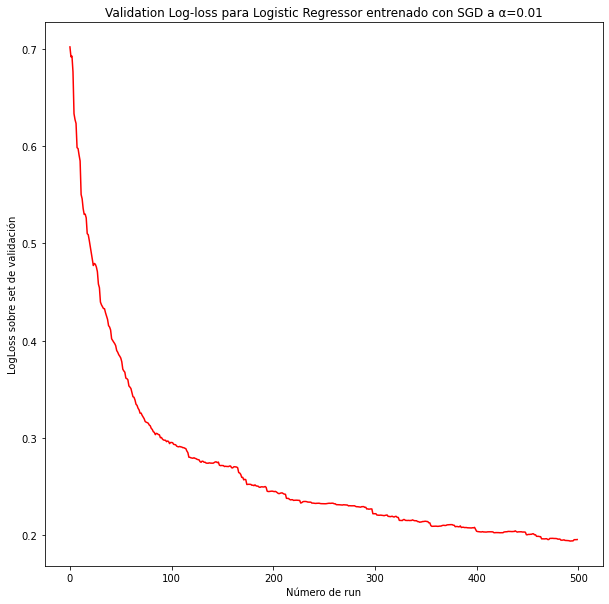

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(historic_loss, color='red')
ax.set_title(f"Validation Log-loss para Logistic Regressor entrenado con SGD a α={lr}")
ax.set_xlabel("Número de run")
ax.set_ylabel("LogLoss sobre set de validación")

ax.plot()

¿Puede seguir mejorando? A explorar:

* Distintos valores de *learning rate* $\alpha$
  * ¿Quién dice que debe ser constante? 
* Entrenar más el modelo (aumentar *n_runs*)
* Sobre el final parecía no mejorar y "rebotar un poco" alrededor de $0.194$, esta variabilidad puede deberse al $\alpha$ o también a la varianza introducida por usar SGD (estimación de gradiente sobre 1 observación).
  * ¿Qué pasa si lo adaptamos para *mini-batch* o incluso *batch*?
* ¿Encapsular en un objeto para no repetir código?

Charlando sobre la varianza del SGD, vamos a correr varios para observar este fenómeno.


In [ ]:
w = rng.standard_normal(size=(dims)) * 0.01
b = rng.uniform(size=1)

def get_historic_loss(w_base,b_base,rng, n_runs, lr):
  w = w_base.copy()
  b = b_base.copy()

  historic_loss = np.empty(n_runs)

  for i in range(n_runs):

    # sample para SGD
    idx = rng.choice(n_rows)
    x = X_train_std[idx]
    y = Y_train[idx]

    # forward
    z = w @ x + b
    y_hat = 1./(1+np.exp(-z))

    # evaluation
    historic_loss[i] = val_error(X_test_std,Y_test,w,b)

    # backwards
    ## derivatives
    dz = y_hat - y
    dw = x * dz
    db = dz

    ## vanilla gradient descent (VGD)
    w -= lr * dw
    b -= lr * db

  return historic_loss

# obtenemos 5 historics con los mismos parámetros iniciales
losses = [get_historic_loss(w,b,rng,n_runs,lr) for i in range(5)]

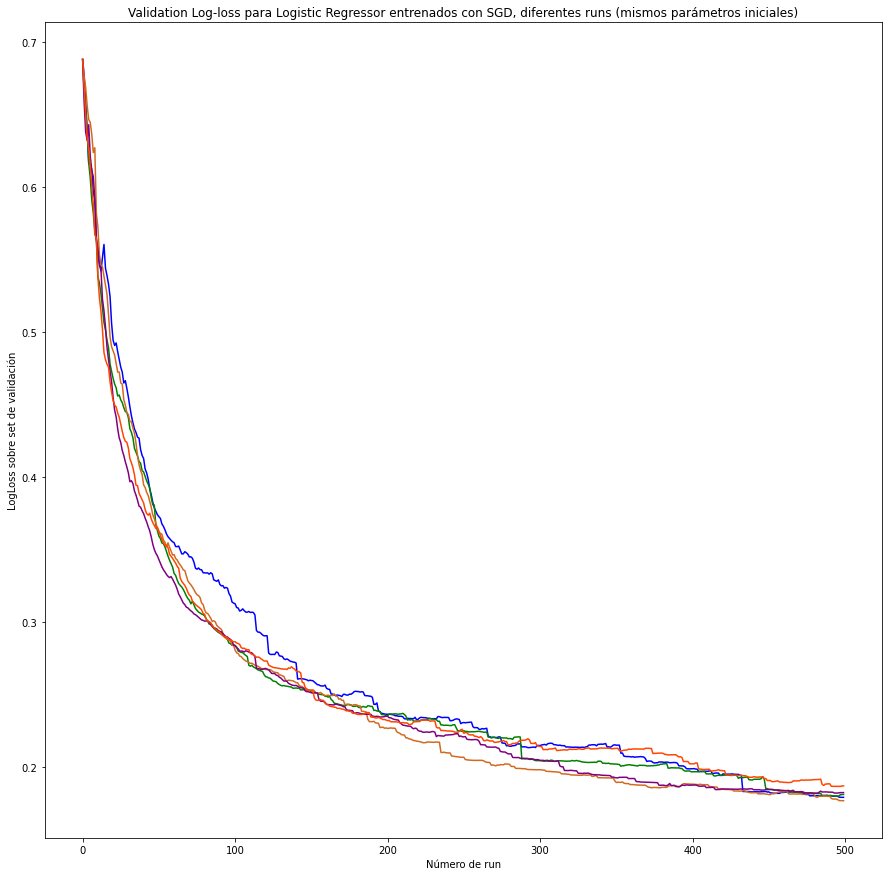

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))

# colores sacados de aca https://matplotlib.org/stable/gallery/color/named_colors.html
colors = ['blue', 'green', 'chocolate', 'purple', 'orangered']

assert len(colors) == len(losses)
for loss,color in zip(losses,colors):
  ax.plot(loss, color=color)
ax.set_title("Validation Log-loss para Logistic Regressor entrenados con SGD, diferentes runs (mismos parámetros iniciales)")
ax.set_xlabel("Número de run")
ax.set_ylabel("LogLoss sobre set de validación")

plt.show()